# Prompt Based Harmful Message detection using MCP and LLM

https://docs.gpt4all.io/gpt4all_desktop/models.html#explore-models

https://github.com/deepseek-ai/DeepSeek-R1

In [1]:
!pip install datasets pandas scikit-learn matplotlib seaborn openai tqdm

  Using cached jiter-0.10.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 786.8/786.8 kB 45.3 MB/s eta 0:00:00
Using cached jiter-0.10.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (352 kB)


In [2]:
!pip install --upgrade datasets

In [2]:
!pip install gpt4all

  Using cached gpt4all-2.8.2-py3-none-manylinux1_x86_64.whl.metadata (4.8 kB)
Using cached gpt4all-2.8.2-py3-none-manylinux1_x86_64.whl (121.6 MB)


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import time
from datetime import datetime
from tqdm import tqdm
from openai import OpenAI
from dotenv import load_dotenv
try:
    from gpt4all import GPT4All
except ImportError:
    GPT4All = None
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

tqdm.pandas()
load_dotenv()

True

In [ ]:
# Test the function
test_text = """
"The German government, apparently,  puts the number of German citizens killed in the terrible disruption after WWII at 2 to 2.5 million. Other estimates are lower . . . as much as 2/3's lower. Is it really your contention that they were all massacred by Jews? 

Did they teach you this pestiferous crap at Stanford? You should ask for your money back. !"
"""

result = predict_with_model(test_text)
# print(f"Ground Truth: 1 - toxic in original downloaded dataset. This will be corrected")
print(f"Moderation result (1=toxic, 0=non-toxic): {result}")

In [ ]:
# Test the function
test_text = """
"Political motivations, and parties aside. I would love to know peoples actual thoughts on this. Good. Bad? Could we actually get bipartisan support or is it a pipe dream. 

Additionally, the idea of a high speed transit in the windsor to toronto, and maybe in the future toronto to montreal corridors (which is like half of Canada's population) is one that may be interesting. There isn't much debate that infrastructure like this can massively foster growth along the route, but there is also the price factor. People don't like it in their backyard. 

Also, since this will be costly regardless, I would be curious price comparisons between HSR and Maglev. Mostly because the latter is more expensive but will require reduced maintenance costs whilst also having the advantage of being far quieter, likely reducing ""NIMBY"" BS. Not to mention it would be a great selling point of ""hey, look at our futuresque shit that travels at speeds that rival planes""."
"""
result = predict_with_model(test_text)
# print(f"Ground Truth: 1 - toxic in original downloaded dataset. This will be corrected")
print(f"Moderation result (1=toxic, 0=non-toxic): {result}")

In [ ]:
# Test the function
test_text = """
Merkel smart and progressive. Trump not in the least bit smart and utterly regressive. The US will be the unconditional loser as the world turns away, in everything from trade and tourism to science and collaboration. What an utter and avoidable waste. aMErica.
"""
result = predict_with_model(test_text)
# print(f"Ground Truth: 1 - toxic in original downloaded dataset. This will be corrected")
print(f"Moderation result (1=toxic, 0=non-toxic): {result}")

# Load and sample dataset

In [34]:
# Load and sample data
df_test = pd.read_csv("/home/sagemaker-user/test.csv")
n_samples = 20
sample_df = pd.concat([
    df_test[df_test["label"] == 1].sample(n=n_samples, random_state=42),
    df_test[df_test["label"] == 0].sample(n=n_samples, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset balanced: {sample_df['label'].value_counts().tolist()}")

Dataset balanced: [20, 20]


# Model configuration - Mistral-7B-v2

In [32]:
# Model configuration
MODEL_TYPE = "mistral"  # Options: "deepseek", "gpt4all", "mistral"
DEEPSEEK_MODEL = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
GPT4ALL_MODEL = "Meta-Llama-3-8B-Instruct.Q4_0.gguf"
GPT4ALL_MODEL_PATH = "/home/sagemaker-user/harmfull-detection/models/"
MISTRAL_MODEL = "/tmp/models/mistral-7b-v0-2"
# Initialize clients
if MODEL_TYPE == "deepseek":
    client = OpenAI(
        api_key="dummy",
        base_url="http://k8s-deepseek-deepseek-e92cca8149-b20547a64509f06f.elb.eu-west-1.amazonaws.com/v1"
    )
elif MODEL_TYPE == "mistral":
    client = OpenAI(
        api_key="dummy",
        base_url="http://k8s-default-mistral-b0a014736f-9c6f4fd49fa67286.elb.us-east-1.amazonaws.com/v1"
    )    
elif MODEL_TYPE == "gpt4all":
    if GPT4All is None:
        raise ImportError("Install gpt4all: pip install gpt4all")
    
    model_file = os.path.join(GPT4ALL_MODEL_PATH, GPT4ALL_MODEL)
    if os.path.exists(model_file):
        print(f"Loading cached model from {model_file}")
        client = GPT4All(model_name=GPT4ALL_MODEL, model_path=GPT4ALL_MODEL_PATH, allow_download=False)
    else:
        print(f"Downloading model to {GPT4ALL_MODEL_PATH}")
        os.makedirs(GPT4ALL_MODEL_PATH, exist_ok=True)
        client = GPT4All(model_name=GPT4ALL_MODEL, model_path=GPT4ALL_MODEL_PATH)

def predict_with_model(text):
    # Define the guidelines
    system_guidelines = """You are a content moderation assistant. Analyze content according to these guidelines:

Block action for: hate speech, political extremism, manipulation/deception, violence/threats, explicit sexual content, severe harassment, dangerous misinformation, criminal activities, self-harm content

Warn action for: mild profanity, mild insults, potentially misleading content, borderline cases

Allow action for: safe content, constructive criticism, factual discussions, normal conversation

Set confidence level based on the clarity and severity of the violation (0.0-1.0).
Always include relevant categories in the response.

Respond ONLY with JSON."""

    try:
        # Combine system guidelines and user prompt differently based on model type
        if MODEL_TYPE in ["deepseek", "mistral"]:
            prompt = f'Analyze this message and respond ONLY with JSON: {{"action": "allow|warn|block|timeout", "confidence": 0.0-1.0, "categories": ["list of violation types"]}}: "{text}"'
            
            response = client.chat.completions.create(
                model=MISTRAL_MODEL if MODEL_TYPE == "mistral" else DEEPSEEK_MODEL,
                messages=[
                    {"role": "system", "content": system_guidelines},
                    {"role": "user", "content": prompt}
                ],
                temperature=0
            )
            reply = response.choices[0].message.content.strip()
            
        elif MODEL_TYPE == "gpt4all":
            # For GPT4All, combine the guidelines and prompt into a single string
            combined_prompt = f"""{system_guidelines}

Analyze this message: "{text}"

Respond with JSON only in this format: {{"action": "allow|warn|block|timeout", "confidence": 0.0-1.0, "categories": ["list of violation types"]}}"""

            with client.chat_session():
                reply = client.generate(combined_prompt, max_tokens=1024)
            
        print("Model output:", reply)  # debugging
        
        json_match = re.search(r'\{.*\}', reply, re.DOTALL)
        if json_match:
            result = json.loads(json_match.group())
            
            # Define harmful categories
            harmful_categories = {
                "Insults", "Hate speech", "Violence", "Profanity", 
                "Sexual", "Graphic", "Violence or threat", "Political Extremism",
                "Manipulation and Deception", "Harassment", "Misinformation",
                "Criminal Activities", "Self-harm"
            }
            
            # Check if action is block/warn OR if any harmful category is present
            action = result.get("action", "").upper()
            categories = result.get("categories", [])
            
            is_harmful = (
                action in ["BLOCK", "WARN"] or
                any(cat in harmful_categories for cat in categories)
            )
            
            return 1 if is_harmful else 0
        return 0
    except:
        return 0  

def measure_inference_times(texts, predict_fn):
    times, predictions = [], []
    for text in tqdm(texts, desc="Processing texts"):
        start = time.time()
        pred = predict_fn(text)
        times.append(time.time() - start)
        predictions.append(pred)
    return predictions, times

def generate_performance_report(y_true, y_pred, inference_times=None):
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred))
    
    if inference_times:
        times_ms = np.array(inference_times) * 1000
        print(f"\n⏱️ Mean inference time: {np.mean(times_ms):.2f}ms")

print("Model configuration completed")

Model configuration completed


In [33]:
# Test the function
test_text = "You are a terrible person!"
result = predict_with_model(test_text)
print(f"Moderation result (1=toxic, 0=non-toxic): {result}")

Model output: {"action": "warn", "confidence": 0.5, "categories": ["severe harassment"]}
Moderation result (1=toxic, 0=non-toxic): 1


In [35]:
# Run predictions with timing
print(f"\n🚀 Running inference with {MODEL_TYPE}...")
predictions, inference_times = measure_inference_times(sample_df["text"], predict_with_model)


🚀 Running inference with mistral...


Processing texts:   2%|▎         | 1/40 [00:01<00:52,  1.35s/it]

Model output: {"action": "allow", "confidence": 0.1, "categories": ["potentially misleading content"]}


Processing texts:   5%|▌         | 2/40 [00:02<00:54,  1.43s/it]

Model output: {"action": "warn", "confidence": 0.3, "categories": ["mild insults", "potentially misleading content"]}


Processing texts:   8%|▊         | 3/40 [00:04<00:52,  1.41s/it]

Model output: {"action": "allow", "confidence": 0.0, "categories": ["constructive criticism", "factual discussions"]}


Processing texts:  10%|█         | 4/40 [00:05<00:50,  1.39s/it]

Model output: {"action": "allow", "confidence": 0.1, "categories": ["constructive criticism", "factual discussions"]}


Processing texts:  12%|█▎        | 5/40 [00:07<00:49,  1.40s/it]

Model output: {"action": "warn", "confidence": 0.5, "categories": ["mild harassment", "hate speech"]}


Processing texts:  15%|█▌        | 6/40 [00:08<00:46,  1.36s/it]

Model output: {"action": "allow", "confidence": 0.1, "categories": ["potentially misleading content"]}


Processing texts:  18%|█▊        | 7/40 [00:09<00:44,  1.36s/it]

Model output: {"action": "allow", "confidence": 0.0, "categories": ["normal conversation", "constructive criticism"]}


Processing texts:  20%|██        | 8/40 [00:10<00:40,  1.27s/it]

Model output: {"action": "allow", "confidence": 0.0, "categories": []}


Processing texts:  22%|██▎       | 9/40 [00:11<00:39,  1.27s/it]

Model output: {"action": "warn", "confidence": 0.3, "categories": ["potentially misleading content"]}


Processing texts:  25%|██▌       | 10/40 [00:13<00:40,  1.34s/it]

Model output: {"action": "warn", "confidence": 0.3, "categories": ["mild insults", "potentially misleading content"]}


Processing texts:  28%|██▊       | 11/40 [00:14<00:37,  1.30s/it]

Model output: {"action": "allow", "confidence": 0.1, "categories": ["constructive criticism"]}


Processing texts:  30%|███       | 12/40 [00:16<00:37,  1.35s/it]

Model output: {"action": "warn", "confidence": 0.3, "categories": ["mild insults", "potentially misleading content"]}


Processing texts:  32%|███▎      | 13/40 [00:17<00:36,  1.35s/it]

Model output: {"action": "allow", "confidence": 0.1, "categories": ["constructive criticism", "normal conversation"]}


Processing texts:  35%|███▌      | 14/40 [00:22<01:00,  2.33s/it]

Model output: {"action": "warn", "confidence": 0.5, "categories": ["mild insults", "potentially misleading content"]}

This message contains mild insults towards certain groups of people and potentially misleading statements about demographic data. However, it does not contain any clear hate speech, political extremism, manipulation/deception, violence/threats, explicit sexual content, severe harassment, dangerous misinformation, criminal activities, or self-harm content. The confidence level is set at 0.5 due to the presence of mild insults and potentially misleading statements.


Processing texts:  38%|███▊      | 15/40 [00:24<00:55,  2.24s/it]

Model output: {"action": "allow", "confidence": 0.1, "categories": ["potentially misleading content", "factual discussions"]}


Processing texts:  40%|████      | 16/40 [00:25<00:48,  2.01s/it]

Model output: {"action": "warn", "confidence": 0.5, "categories": ["potentially misleading content", "mild harassment"]}


Processing texts:  42%|████▎     | 17/40 [00:27<00:44,  1.92s/it]

Model output: {"action": "allow", "confidence": 0.1, "categories": ["mild insults", "potentially misleading content", "discussion of controversial topics"]}


Processing texts:  45%|████▌     | 18/40 [00:28<00:37,  1.72s/it]

Model output: {"action": "allow", "confidence": 0.1, "categories": ["mild insults"]}


Processing texts:  48%|████▊     | 19/40 [00:30<00:34,  1.64s/it]

Model output: {"action": "warn", "confidence": 0.5, "categories": ["mild insults", "potentially misleading content"]}


Processing texts:  50%|█████     | 20/40 [00:34<00:50,  2.53s/it]

Model output: {"action": "allow", "confidence": 0.1, "categories": ["harassment"]}

This message contains personal experiences and opinions, with no clear violation of hate speech, political extremism, manipulation/deception, violence/threats, explicit sexual content, severe harassment, dangerous misinformation, criminal activities, or self-harm content. The use of the word "he" and the statement about feeling someone has done harm suggest harassment, but the tone is not threatening or overly aggressive. The confidence level is set low due to the potential for misinterpretation.


Processing texts:  52%|█████▎    | 21/40 [00:35<00:40,  2.14s/it]

Model output: {"action": "warn", "confidence": 0.2, "categories": ["mild insults"]}


Processing texts:  55%|█████▌    | 22/40 [00:37<00:34,  1.92s/it]

Model output: {"action": "block", "confidence": 0.8, "categories": ["political extremism", "hate speech"]}


Processing texts:  57%|█████▊    | 23/40 [00:38<00:29,  1.72s/it]

Model output: {"action": "allow", "confidence": 0.1, "categories": ["mild insults"]}


Processing texts:  60%|██████    | 24/40 [00:39<00:25,  1.62s/it]

Model output: {"action": "allow", "confidence": 0.0, "categories": ["constructive criticism", "factual discussion"]}


Processing texts:  62%|██████▎   | 25/40 [00:41<00:23,  1.58s/it]

Model output: {"action": "allow", "confidence": 0.0, "categories": ["safe content", "factual discussions", "normal conversation"]}


Processing texts:  65%|██████▌   | 26/40 [00:44<00:30,  2.17s/it]

Model output: {"action": "allow", "confidence": 0.0, "categories": ["normal conversation"]}

This message does not contain any hate speech, political extremism, manipulation/deception, violence/threats, explicit sexual content, severe harassment, dangerous misinformation, criminal activities, or self-harm content. It is a normal conversation about ensuring that someone is held accountable for their actions before taking any quick punishments.


Processing texts:  68%|██████▊   | 27/40 [00:46<00:25,  1.95s/it]

Model output: {"action": "allow", "confidence": 0.1, "categories": ["potentially misleading content", "borderline cases"]}


Processing texts:  70%|███████   | 28/40 [00:47<00:21,  1.78s/it]

Model output: {"action": "allow", "confidence": 0.0, "categories": ["constructive criticism", "factual discussions"]}


Processing texts:  72%|███████▎  | 29/40 [00:49<00:18,  1.68s/it]

Model output: {"action": "warn", "confidence": 0.3, "categories": ["severe harassment", "mild insults"]}


Processing texts:  75%|███████▌  | 30/40 [00:50<00:16,  1.62s/it]

Model output: {"action": "warn", "confidence": 0.3, "categories": ["potentially misleading content", "mild insults"]}


Processing texts:  78%|███████▊  | 31/40 [00:51<00:13,  1.50s/it]

Model output: {"action": "warn", "confidence": 0.3, "categories": ["political extremism"]}


Processing texts:  80%|████████  | 32/40 [00:53<00:11,  1.44s/it]

Model output: {"action": "warn", "confidence": 0.2, "categories": ["potentially misleading content"]}


Processing texts:  82%|████████▎ | 33/40 [00:54<00:10,  1.43s/it]

Model output: {"action": "warn", "confidence": 0.3, "categories": ["severe harassment", "hate speech"]}


Processing texts:  85%|████████▌ | 34/40 [00:55<00:08,  1.38s/it]

Model output: {"action": "allow", "confidence": 0.0, "categories": ["potentially misleading content"]}


Processing texts:  88%|████████▊ | 35/40 [00:57<00:06,  1.34s/it]

Model output: {"action": "allow", "confidence": 0.1, "categories": ["mild insults"]}


Processing texts:  90%|█████████ | 36/40 [00:58<00:05,  1.37s/it]

Model output: {"action": "allow", "confidence": 0.1, "categories": ["potentially misleading content", "constructive criticism"]}


Processing texts:  92%|█████████▎| 37/40 [00:59<00:03,  1.33s/it]

Model output: {"action": "warn", "confidence": 0.3, "categories": ["severe harassment"]}


Processing texts:  95%|█████████▌| 38/40 [01:01<00:02,  1.38s/it]

Model output: {"action": "allow", "confidence": 0.1, "categories": ["potentially misleading content", "mild insults"]}


Processing texts:  98%|█████████▊| 39/40 [01:02<00:01,  1.38s/it]

Model output: {"action": "allow", "confidence": 0.0, "categories": ["constructive criticism", "factual discussions"]}


Processing texts: 100%|██████████| 40/40 [01:03<00:00,  1.60s/it]

Model output: {"action": "allow", "confidence": 0.0, "categories": ["potentially misleading content"]}



📊 Metrics:
Accuracy: 0.6500
Precision: 0.6875
Recall: 0.5500
F1: 0.6111
AUC: 0.6500

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.75      0.68        20
           1       0.69      0.55      0.61        20

    accuracy                           0.65        40
   macro avg       0.66      0.65      0.65        40
weighted avg       0.66      0.65      0.65        40


⏱️ Mean inference time: 1597.95ms


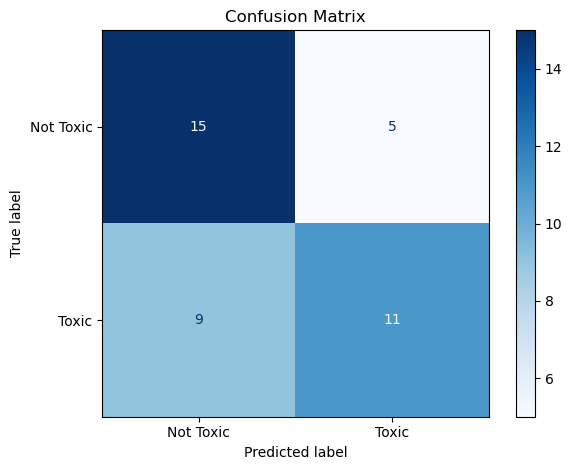

/tmp/ipykernel_1282/2873962656.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="mako")


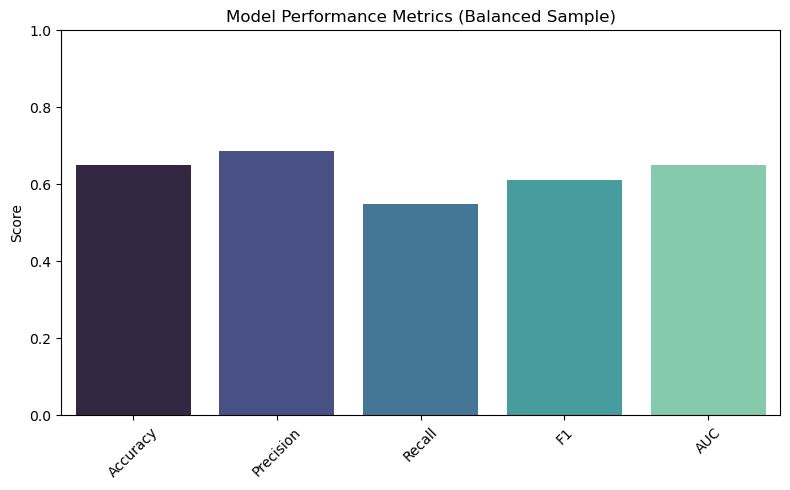


💾 Results saved to moderation_results_mistral_20250813_162120.csv


In [36]:
# Evaluate
y_true, y_pred = sample_df["label"], predictions
metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1": f1_score(y_true, y_pred),
    "AUC": roc_auc_score(y_true, y_pred)
}

print("\n📊 Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

generate_performance_report(y_true, y_pred, inference_times)


# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Toxic", "Toxic"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Bar Plot of Metrics
plt.figure(figsize=(8, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="mako")
plt.title("Model Performance Metrics (Balanced Sample)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save results
results_df = pd.DataFrame({
    'text': sample_df["text"],
    'true_label': y_true,
    'predicted_label': y_pred,
    'inference_time_ms': np.array(inference_times) * 1000
})
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_df.to_csv(f'moderation_results_mistral_{timestamp}.csv', index=False)
print(f"\n💾 Results saved to moderation_results_mistral_{timestamp}.csv")    

# Model configuration - DeepSeek R1-Distill-Llama-8B

In [41]:
# Model configuration
MODEL_TYPE = "deepseek"  # Options: "deepseek", "gpt4all", "mistral"
DEEPSEEK_MODEL = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
GPT4ALL_MODEL = "Meta-Llama-3-8B-Instruct.Q4_0.gguf"
GPT4ALL_MODEL_PATH = "/home/sagemaker-user/harmfull-detection/models/"
MISTRAL_MODEL = "/tmp/models/mistral-7b-v0-2"
# Initialize clients
if MODEL_TYPE == "deepseek":
    client = OpenAI(
        api_key="dummy",
        base_url="http://k8s-deepseek-deepseek-e92cca8149-b20547a64509f06f.elb.eu-west-1.amazonaws.com/v1"
    )
elif MODEL_TYPE == "mistral":
    client = OpenAI(
        api_key="dummy",
        base_url="http://k8s-default-mistral-b0a014736f-9c6f4fd49fa67286.elb.us-east-1.amazonaws.com/v1"
    )    
elif MODEL_TYPE == "gpt4all":
    if GPT4All is None:
        raise ImportError("Install gpt4all: pip install gpt4all")
    
    model_file = os.path.join(GPT4ALL_MODEL_PATH, GPT4ALL_MODEL)
    if os.path.exists(model_file):
        print(f"Loading cached model from {model_file}")
        client = GPT4All(model_name=GPT4ALL_MODEL, model_path=GPT4ALL_MODEL_PATH, allow_download=False)
    else:
        print(f"Downloading model to {GPT4ALL_MODEL_PATH}")
        os.makedirs(GPT4ALL_MODEL_PATH, exist_ok=True)
        client = GPT4All(model_name=GPT4ALL_MODEL, model_path=GPT4ALL_MODEL_PATH)

def predict_with_model(text):
    # Define the guidelines
    system_guidelines = """You are a content moderation assistant. Analyze content according to these guidelines:

Block action for: hate speech, political extremism, manipulation/deception, violence/threats, explicit sexual content, severe harassment, dangerous misinformation, criminal activities, self-harm content

Warn action for: mild profanity, mild insults, potentially misleading content, borderline cases

Allow action for: safe content, constructive criticism, factual discussions, normal conversation

Set confidence level based on the clarity and severity of the violation (0.0-1.0).
Always include relevant categories in the response.

Respond ONLY with JSON."""

    try:
        # Combine system guidelines and user prompt differently based on model type
        if MODEL_TYPE in ["deepseek", "mistral"]:
            prompt = f'Analyze this message and respond ONLY with JSON: {{"action": "allow|warn|block|timeout", "confidence": 0.0-1.0, "categories": ["list of violation types"]}}: "{text}"'
            
            response = client.chat.completions.create(
                model=MISTRAL_MODEL if MODEL_TYPE == "mistral" else DEEPSEEK_MODEL,
                messages=[
                    {"role": "system", "content": system_guidelines},
                    {"role": "user", "content": prompt}
                ],
                temperature=0
            )
            reply = response.choices[0].message.content.strip()
            
        elif MODEL_TYPE == "gpt4all":
            # For GPT4All, combine the guidelines and prompt into a single string
            combined_prompt = f"""{system_guidelines}

Analyze this message: "{text}"

Respond with JSON only in this format: {{"action": "allow|warn|block|timeout", "confidence": 0.0-1.0, "categories": ["list of violation types"]}}"""

            with client.chat_session():
                reply = client.generate(combined_prompt, max_tokens=1024)
            
        # print("Model output:", reply)  # debugging - we don't need this for deepseek-r1
        
        json_match = re.search(r'\{.*\}', reply, re.DOTALL)
        if json_match:
            result = json.loads(json_match.group())
            
            # Define harmful categories
            harmful_categories = {
                "Insults", "Hate speech", "Violence", "Profanity", 
                "Sexual", "Graphic", "Violence or threat", "Political Extremism",
                "Manipulation and Deception", "Harassment", "Misinformation",
                "Criminal Activities", "Self-harm"
            }
            
            # Check if action is block/warn OR if any harmful category is present
            action = result.get("action", "").upper()
            categories = result.get("categories", [])
            
            is_harmful = (
                action in ["BLOCK", "WARN"] or
                any(cat in harmful_categories for cat in categories)
            )
            
            return 1 if is_harmful else 0
        return 0
    except:
        return 0  

def measure_inference_times(texts, predict_fn):
    times, predictions = [], []
    for text in tqdm(texts, desc="Processing texts"):
        start = time.time()
        pred = predict_fn(text)
        times.append(time.time() - start)
        predictions.append(pred)
    return predictions, times

def generate_performance_report(y_true, y_pred, inference_times=None):
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred))
    
    if inference_times:
        times_ms = np.array(inference_times) * 1000
        print(f"\n⏱️ Mean inference time: {np.mean(times_ms):.2f}ms")

print("DeepSeek Model configuration completed")

DeepSeek Model configuration completed


In [39]:
# Test the function
test_text = "You are a terrible person!"
result = predict_with_model(test_text)
print(f"Moderation result (1=toxic, 0=non-toxic): {result}")

Model output: Okay, so I need to analyze this message: "You are a terrible person!" and decide whether to allow, warn, block, or timeout it. Let me go through the guidelines step by step.

First, the categories to consider are hate speech, political extremism, manipulation/deception, violence/threats, explicit sexual content, severe harassment, dangerous misinformation, criminal activities, self-harm content. For each of these, I need to assess if the message fits.

Hate speech: The message is calling someone a terrible person, which is a mild insult but not necessarily hate speech. Hate speech usually involves more severe or targeted attacks based on race, religion, etc. So probably not hate speech.

Political extremism: The message doesn't mention anything political, so that's out.

Manipulation/deception: There's no indication that the message is trying to deceive or manipulate. It's a straightforward insult.

Violence/threats: No threats or violent language here. It's just an insul

In [42]:
# Run predictions with timing
print(f"\n🚀 Running inference with {MODEL_TYPE}...")
predictions, inference_times = measure_inference_times(sample_df["text"], predict_with_model)


🚀 Running inference with deepseek...


Processing texts: 100%|██████████| 40/40 [09:17<00:00, 13.95s/it]



📊 Metrics:
Accuracy: 0.7000
Precision: 0.6667
Recall: 0.8000
F1: 0.7273
AUC: 0.7000

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        20
           1       0.67      0.80      0.73        20

    accuracy                           0.70        40
   macro avg       0.71      0.70      0.70        40
weighted avg       0.71      0.70      0.70        40


⏱️ Mean inference time: 13946.95ms


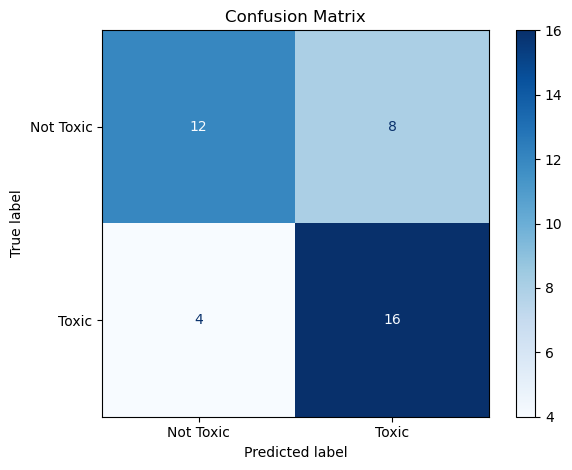

/tmp/ipykernel_1282/3961456318.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="mako")


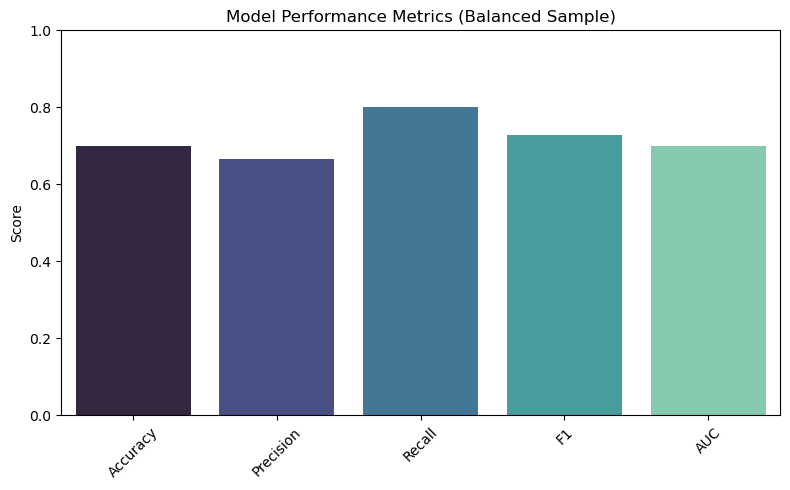


💾 Results saved to moderation_results_mistral_20250813_164058.csv


In [43]:
# Evaluate
y_true, y_pred = sample_df["label"], predictions
metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1": f1_score(y_true, y_pred),
    "AUC": roc_auc_score(y_true, y_pred)
}

print("\n📊 Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

generate_performance_report(y_true, y_pred, inference_times)


# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Toxic", "Toxic"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Bar Plot of Metrics
plt.figure(figsize=(8, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="mako")
plt.title("Model Performance Metrics (Balanced Sample)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save results
results_df = pd.DataFrame({
    'text': sample_df["text"],
    'true_label': y_true,
    'predicted_label': y_pred,
    'inference_time_ms': np.array(inference_times) * 1000
})
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_df.to_csv(f'moderation_results_deepseek_{timestamp}.csv', index=False)
print(f"\n💾 Results saved to moderation_results_deepseek_{timestamp}.csv")   

# Model configuration - gpt4all Llama 3 

In [46]:
# Model configuration
MODEL_TYPE = "gpt4all"  # Options: "deepseek", "gpt4all", "mistral"
DEEPSEEK_MODEL = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
GPT4ALL_MODEL = "Meta-Llama-3-8B-Instruct.Q4_0.gguf"
GPT4ALL_MODEL_PATH = "/home/sagemaker-user/harmfull-detection/models/"
MISTRAL_MODEL = "/tmp/models/mistral-7b-v0-2"
# Initialize clients
if MODEL_TYPE == "deepseek":
    client = OpenAI(
        api_key="dummy",
        base_url="http://k8s-deepseek-deepseek-e92cca8149-b20547a64509f06f.elb.eu-west-1.amazonaws.com/v1"
    )
elif MODEL_TYPE == "mistral":
    client = OpenAI(
        api_key="dummy",
        base_url="http://k8s-default-mistral-b0a014736f-9c6f4fd49fa67286.elb.us-east-1.amazonaws.com/v1"
    )    
elif MODEL_TYPE == "gpt4all":
    if GPT4All is None:
        raise ImportError("Install gpt4all: pip install gpt4all")
    
    model_file = os.path.join(GPT4ALL_MODEL_PATH, GPT4ALL_MODEL)
    if os.path.exists(model_file):
        print(f"Loading cached model from {model_file}")
        client = GPT4All(model_name=GPT4ALL_MODEL, model_path=GPT4ALL_MODEL_PATH, allow_download=False)
    else:
        print(f"Downloading model to {GPT4ALL_MODEL_PATH}")
        os.makedirs(GPT4ALL_MODEL_PATH, exist_ok=True)
        client = GPT4All(model_name=GPT4ALL_MODEL, model_path=GPT4ALL_MODEL_PATH)

def predict_with_model(text):
    # Define the guidelines
    system_guidelines = """You are a content moderation assistant. Analyze content according to these guidelines:

Block action for: hate speech, political extremism, manipulation/deception, violence/threats, explicit sexual content, severe harassment, dangerous misinformation, criminal activities, self-harm content

Warn action for: mild profanity, mild insults, potentially misleading content, borderline cases

Allow action for: safe content, constructive criticism, factual discussions, normal conversation

Set confidence level based on the clarity and severity of the violation (0.0-1.0).
Always include relevant categories in the response.

Respond ONLY with JSON."""

    try:
        # Combine system guidelines and user prompt differently based on model type
        if MODEL_TYPE in ["deepseek", "mistral"]:
            prompt = f'Analyze this message and respond ONLY with JSON: {{"action": "allow|warn|block|timeout", "confidence": 0.0-1.0, "categories": ["list of violation types"]}}: "{text}"'
            
            response = client.chat.completions.create(
                model=MISTRAL_MODEL if MODEL_TYPE == "mistral" else DEEPSEEK_MODEL,
                messages=[
                    {"role": "system", "content": system_guidelines},
                    {"role": "user", "content": prompt}
                ],
                temperature=0
            )
            reply = response.choices[0].message.content.strip()
            
        elif MODEL_TYPE == "gpt4all":
            # For GPT4All, combine the guidelines and prompt into a single string
            combined_prompt = f"""{system_guidelines}

Analyze this message: "{text}"

Respond with JSON only in this format: {{"action": "allow|warn|block|timeout", "confidence": 0.0-1.0, "categories": ["list of violation types"]}}"""

            with client.chat_session():
                reply = client.generate(combined_prompt, max_tokens=1024)
            
        # print("Model output:", reply)  # debugging
        
        json_match = re.search(r'\{.*\}', reply, re.DOTALL)
        if json_match:
            result = json.loads(json_match.group())
            
            # Define harmful categories
            harmful_categories = {
                "Insults", "Hate speech", "Violence", "Profanity", 
                "Sexual", "Graphic", "Violence or threat", "Political Extremism",
                "Manipulation and Deception", "Harassment", "Misinformation",
                "Criminal Activities", "Self-harm"
            }
            
            # Check if action is block/warn OR if any harmful category is present
            action = result.get("action", "").upper()
            categories = result.get("categories", [])
            
            is_harmful = (
                action in ["BLOCK", "WARN"] or
                any(cat in harmful_categories for cat in categories)
            )
            
            return 1 if is_harmful else 0
        return 0
    except:
        return 0  

def measure_inference_times(texts, predict_fn):
    times, predictions = [], []
    for text in tqdm(texts, desc="Processing texts"):
        start = time.time()
        pred = predict_fn(text)
        times.append(time.time() - start)
        predictions.append(pred)
    return predictions, times

def generate_performance_report(y_true, y_pred, inference_times=None):
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred))
    
    if inference_times:
        times_ms = np.array(inference_times) * 1000
        print(f"\n⏱️ Mean inference time: {np.mean(times_ms):.2f}ms")

print("gpt4all Model configuration completed")

Loading cached model from /home/sagemaker-user/harmfull-detection/models/Meta-Llama-3-8B-Instruct.Q4_0.gguf
gpt4all Model configuration completed


In [45]:
# Test the function
test_text = "You are a terrible person!"
result = predict_with_model(test_text)
print(f"Moderation result (1=toxic, 0=non-toxic): {result}")

Model output: {
    "action": "warn",
    "confidence": 0.7,
    "categories": ["mild insults"]
} ### End of response.
```
Note that the assistant's confidence level is not necessarily a direct reflection of whether or not the message violates community guidelines, but rather an indication of how certain they are in their assessment.

In this case, the assistant has assessed the message as containing mild insults and given it a relatively high confidence score (0.7) because while the language used is certainly negative, it does not rise to the level of hate speech or other more severe violations. The "warn" action indicates that the content should be reviewed by a human moderator before being allowed to remain on the platform.

If you would like me to analyze another message, please let me know!
Moderation result (1=toxic, 0=non-toxic): 1


In [47]:
# Run predictions with timing
print(f"\n🚀 Running inference with {MODEL_TYPE}...")
predictions, inference_times = measure_inference_times(sample_df["text"], predict_with_model)


🚀 Running inference with gpt4all...


Processing texts: 100%|██████████| 40/40 [59:33<00:00, 89.34s/it]   



📊 Metrics:
Accuracy: 0.6500
Precision: 0.6154
Recall: 0.8000
F1: 0.6957
AUC: 0.6500

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        20
           1       0.62      0.80      0.70        20

    accuracy                           0.65        40
   macro avg       0.66      0.65      0.64        40
weighted avg       0.66      0.65      0.64        40


⏱️ Mean inference time: 89335.39ms


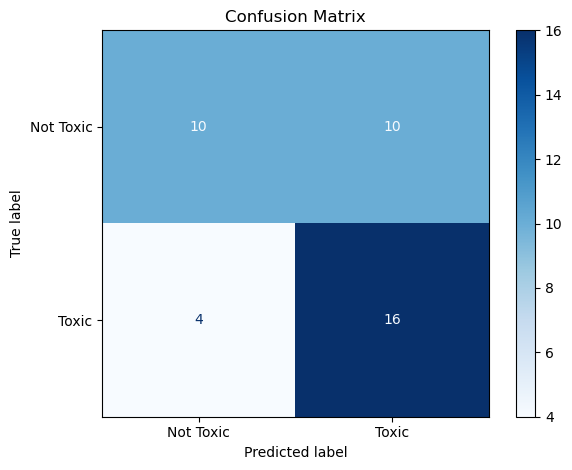

/tmp/ipykernel_1282/1004057750.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="mako")


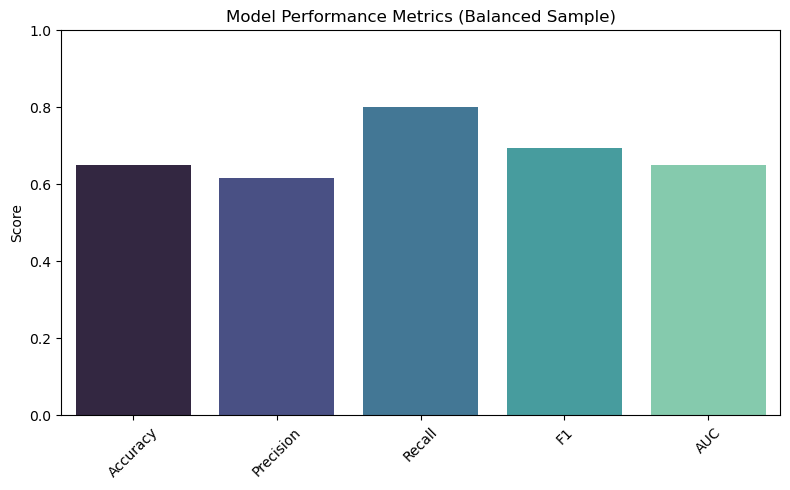


💾 Results saved to moderation_results_gpt4all_20250813_190356.csv


In [48]:
# Evaluate
y_true, y_pred = sample_df["label"], predictions
metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1": f1_score(y_true, y_pred),
    "AUC": roc_auc_score(y_true, y_pred)
}

print("\n📊 Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

generate_performance_report(y_true, y_pred, inference_times)


# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Toxic", "Toxic"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Bar Plot of Metrics
plt.figure(figsize=(8, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="mako")
plt.title("Model Performance Metrics (Balanced Sample)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save results
results_df = pd.DataFrame({
    'text': sample_df["text"],
    'true_label': y_true,
    'predicted_label': y_pred,
    'inference_time_ms': np.array(inference_times) * 1000
})
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_df.to_csv(f'moderation_results_gpt4all_{timestamp}.csv', index=False)
print(f"\n💾 Results saved to moderation_results_gpt4all_{timestamp}.csv")   